In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Perform basic dimension check

#Read in full toxicity dataset
data = pd.read_csv('toxicity_data.csv')

#Output dimensions of the data
print("Dimensions of toxicity data:")
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

Dimensions of toxicity data:
Number of rows: 171
Number of columns: 1204


In [75]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [76]:
def test_sigmoid():
    #Sample case
    test_inputs = [0, 1, -1, 10, -10]
    expected_outputs = [0.5, 0.73105858, 0.26894142, 0.9999546, 4.53978687e-05]
    for input_val, expected_output in zip(test_inputs, expected_outputs):
        output = sigmoid(input_val)
        assert np.isclose(output, expected_output), f"Test failed: Input {input_val}, Expected {expected_output}, Got {output}"

    print("Sigmoid function test passed.")
test_sigmoid()

Sigmoid function test passed.


In [101]:
def logistic_regression(X, y, learning_rate=0.001, n_iters=1000):
    """
    Fit logistic regression model to the data.
    """
    n_samples, n_features = X.shape

    # Initialize parameters
    weights = np.zeros(n_features)
    bias = 0

    # Gradient descent
    for _ in range(n_iters):
        # Linear combination of weights and features, plus bias
        linear_model = np.dot(X, weights) + bias
        # Apply sigmoid function
        y_predicted = sigmoid(linear_model)

        #Compute gradients
        dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
        db = (1 / n_samples) * np.sum(y_predicted - y)        

        # Update parameters
        weights -= learning_rate * dw
        bias -= learning_rate * db

    return weights, bias

def logistic_regression_predict(X, weights, bias):
    """
    Predict using logistic regression model.
    """
    linear_model = np.dot(X, weights) + bias
    y_predicted = sigmoid(linear_model)
    y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
    return np.array(y_predicted_cls)

"""
def sigmoid(x):
    if -x > np.log(np.finfo(type(x)).max):
        return 0.0
    dist = np.exp(-value)
    return 1 / (1 + dist)
"""

def select_best_feature(X, y, selected_features):
    remaining_features = [i for i in range(X.shape[1]) if i not in selected_features]
    best_score = -np.inf
    best_feature = None

    for feature in remaining_features:
        X_temp = X[:, selected_features + [feature]]
        weights, bias, _ = logistic_regression(X_temp, y)

        linear_model = np.dot(X_temp, weights) + bias
        y_predicted = sigmoid(linear_model)

        score = compute_score(y, y_predicted)
        if score > best_score:
            best_score = score
            best_feature = feature

    return best_feature

def compute_score(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [78]:
def test_compute_score():
    #Test cases
    y_true = np.array([0, 1, 0, 1, 1])
    y_pred = np.array([0, 1, 0, 0, 1])
    expected_output = 0.8

    #Run
    output = compute_score(y_true, y_pred)
    assert np.isclose(output, expected_output), f"Test failed: Expected {expected_output}, Got {output}"

    print("Compute score function test passed.")
#test_compute_score()

Compute score function test passed.


In [114]:
#Log normalize the numerical data
#data = np.log1p(data)

#Toxicity data has class variable (toxic vs nontoxic) as target variable
X = data.drop('Class', axis=1) 
y = data['Class']


#Print XPortion
print("Input features for logistic regression (X):")
X = X.to_numpy()
print(X)
print(type(X))
#Print YPortion
print("Target variable for logistic regression:")
print(y.head())

#Convert target variable numeric
#0 FOR NONTOXIC
#1 FOR TOXIC
y_numeric = [0 if label == 'NonToxic' else 1 for label in y]
#Convert to numpy array
y_numeric = np.array(y_numeric)

#Print YNumericPortion
print("Target variable for logistic regression:")
print(y_numeric)
print(type(y_numeric))

Input features for logistic regression (X):
[[ 9.080e-02  0.000e+00  7.500e-03 ...  0.000e+00 -8.680e-02  0.000e+00]
 [ 2.130e-02  0.000e+00  1.144e-01 ...  0.000e+00 -8.100e-02  2.500e-01]
 [ 1.800e-03  0.000e+00 -1.560e-02 ...  0.000e+00 -1.004e-01  0.000e+00]
 ...
 [ 9.600e-03  2.000e+00 -1.846e-01 ...  0.000e+00 -9.270e-02  0.000e+00]
 [-7.360e-02  2.000e+00 -1.267e-01 ...  0.000e+00 -1.129e-01  0.000e+00]
 [-1.864e-01  0.000e+00 -2.000e-03 ...  0.000e+00 -1.915e-01  0.000e+00]]
<class 'numpy.ndarray'>
Target variable for logistic regression:
0    NonToxic
1    NonToxic
2    NonToxic
3    NonToxic
4    NonToxic
Name: Class, dtype: object
Target variable for logistic regression:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [80]:
#Function for splitting data into training/testing sections
def train_test_split(X, y, test_size=0.2, random_state=None):
    """Split the dataset into training and testing sets."""
    if random_state is not None:
        np.random.seed(random_state)

    #Shuffle indices
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    #Calculate the number of samples for the testing set
    num_test_samples = int(len(X) * test_size)

    #Split the shuffled indices into training and testing indices
    test_indices = indices[:num_test_samples]
    train_indices = indices[num_test_samples:]

    #Split the dataset into training and testing sets
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

In [115]:
#X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)
#Test train/test split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

#Normalize TEST using standard scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Shape of X_train: (136, 1203)
Shape of X_test: (35, 1203)
Shape of y_train: (136,)
Shape of y_test: (35,)


In [106]:
#XTrain
print(X_train)
#XTest
print(X_test)
#YTrain
print(y_train)
#YTest
print(y_test)

[[-0.5529571  -0.41476803  0.3936984  ... -0.12206284  1.43727499
  -0.25784809]
 [-1.17161905 -0.41476803 -0.71761032 ... -0.12206284 -0.4357783
  -0.25784809]
 [-0.69687044 -0.41476803  0.9045161  ... -0.12206284  0.86721529
  -0.25784809]
 ...
 [ 1.98124107 -0.41476803 -0.55587807 ... -0.12206284  0.39895197
  -0.25784809]
 [-0.69521626 -0.41476803 -0.37973404 ... -0.12206284 -0.06931136
  -0.25784809]
 [-0.82755037 -0.41476803 -0.53666236 ... -0.12206284  0.42609767
  -0.25784809]]
[[-0.22212183  0.81150267 -0.53345974 ... -0.12206284  1.27779401
  -0.25784809]
 [-0.46363157  2.03777337 -0.52385189 ... -0.12206284  0.58897187
  -0.25784809]
 [-0.09971278 -0.41476803  0.67552885 ... -0.12206284  0.75184607
  -0.25784809]
 ...
 [-0.57446139 -0.41476803  2.10870077 ... -0.12206284  0.48038907
  -0.25784809]
 [-0.94665107 -0.41476803 -1.23002933 ... -0.12206284  1.72230484
  -0.25784809]
 [-0.02527484 -0.41476803 -1.05548661 ... -0.12206284 -1.20603754
  -0.25784809]]
[1 0 0 0 1 1 1 1 

Accuracy: 51.43%
Accuracy: 48.57%
Accuracy: 48.57%
Accuracy: 45.71%
Accuracy: 45.71%
Accuracy: 51.43%
Accuracy: 51.43%
Accuracy: 57.14%
Accuracy: 57.14%
Accuracy: 57.14%
Accuracy: 57.14%
Accuracy: 57.14%
Accuracy: 57.14%
Accuracy: 57.14%


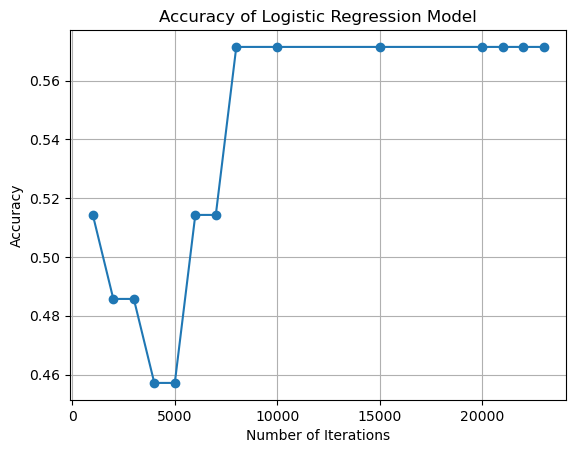

In [119]:
#Switch hyperparameters up
learning_rate = 0.001
num_iterations_list = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000, 15000, 20000, 21000, 22000, 23000]

#Train the logistic regression model and evaluate accuracy for each number of iterations
accuracy_scores = []
for num_iterations in num_iterations_list:
    #Training step
    weights, bias = logistic_regression(X_train, y_train, learning_rate, num_iterations)
    
    #Make predictions on the test data
    y_pred = logistic_regression_predict(X_test, weights, bias)
    
    #Calculate accuracy
    acc = compute_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(acc* 100))
    accuracy_scores.append(acc)

#Plot accuracy over iterations
plt.plot(num_iterations_list, accuracy_scores, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy of Logistic Regression Model')
plt.grid(True)
plt.show()

In [124]:
#Evaluate coefficients
print(weights)

[-0.02204303 -0.03856443 -0.03036437 ... -0.00188981  0.01592053
  0.17074792]


In [120]:
#Test with sklearn
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

#Read in full toxicity dataset
data = pd.read_csv('toxicity_data.csv')
sc = StandardScaler()
X = data.drop('Class', axis=1) 
X = sc.fit_transform(X)
y = data['Class']

#Binarize
y = [0 if label == 'NonToxic' else 1 for label in y]
#Convert to numpy array
y = np.array(y)

#Split into test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 16)
#Normalize TEST using standard scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

logreg = LogisticRegression(random_state=16, max_iter=200000)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
threshold = 0.5
logreg.predict(X_test)

print(y_test)
(logreg.predict_proba(X_test)[:,1]>threshold).astype(int)

[1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0
 0 0 0 1 1 0]


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

C:\Users\Brian\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Brian\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 44.19%
Accuracy: 48.84%
Accuracy: 55.81%
Accuracy: 55.81%
Accuracy: 55.81%
Accuracy: 55.81%
Accuracy: 55.81%
Accuracy: 55.81%


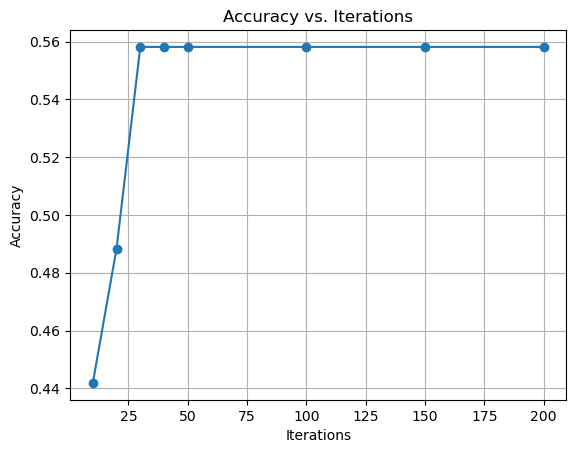

In [121]:
# Initialize lists to store accuracy and regularization parameter values
accuracies = []
iter_counts = [10, 20, 30, 40, 50, 100, 150, 200]

# Train the model with different values of regularization parameter
for it in iter_counts:
    # Initialize logistic regression model with specific regularization parameter
    logreg = LogisticRegression(random_state=7, max_iter=it)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    # Calculate accuracy and append to list
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    accuracies.append(accuracy)
    
    # Append regularization parameter value to list
    #regularization_values.append(C_value)

#Plot accuracy vs. regularization parameter values
plt.plot(iter_counts, accuracies, marker='o')
plt.title('Accuracy vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [122]:
rfe = RFE(logreg, n_features_to_select=13)
rfe.fit(X, y)

print(rfe.support_)

[False False False ... False False False]
